In [1]:
from init import *
from utils import config,device,show__random_img,calculate_mean_std_mnist

In [2]:
# Float16
torch.amp.autocast('cuda',enabled=False)

# REPRODUCE
torch.backends.cudnn.deterministi=True
random.seed(hash('setting random seeds')% 2**32-1)
np.random.seed(hash('improves reproducibility')%2**32-1)
torch.manual_seed(hash("by removing stochasticity")%2**32-1)
torch.cuda.manual_seed_all(hash('so runs are repetable')%2**32-1)

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


In [4]:
train_data = datasets.MNIST(config['data'].get('dir_path'), train=True, download=False, transform=train_transforms)
test_data = datasets.MNIST(config['data'].get('dir_path'), train=False, download=False, transform=test_transforms)

In [5]:
batch_size = 64

if torch.cuda.is_available():
    kwargs = {'batch_size': 64, 'shuffle': True, 'num_workers': 3, 'pin_memory': True}
else:
    kwargs = {'batch_size':32,'shuffle':True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

In [6]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)
    
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

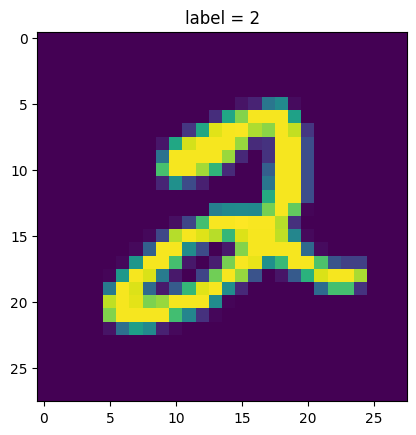

In [7]:
for i in random.choices(np.arange(0,20),k=1):
    plt.imshow(train_data.data[i])
    plt.title(f'label = {train_data.targets[i].numpy()}')
    plt.show()

### Model 1

In [8]:
from model import Net

In [9]:
model = Net().to(device)
# for name,weights in model.named_parameters():
#     print(f"{name}\t\t {weights.shape}")

summary(model=model,input_size=(1,1,28,28),device='cuda');

optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)
# New Line
criterion =  F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

/home/muthu/miniconda3/envs/venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1


Train: Loss=0.1573 Batch_id=937 Accuracy=92.74: 100%|██████████| 938/938 [00:06<00:00, 153.25it/s]


Test set: Average loss: 0.0574, Accuracy: 9810/10000 (98.1000%)

Epoch 2


Train: Loss=0.0476 Batch_id=937 Accuracy=97.14: 100%|██████████| 938/938 [00:05<00:00, 162.25it/s]


Test set: Average loss: 0.0442, Accuracy: 9867/10000 (98.6700%)

Epoch 3


Train: Loss=0.0301 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:05<00:00, 160.10it/s]


Test set: Average loss: 0.0297, Accuracy: 9903/10000 (99.0300%)

Epoch 4


Train: Loss=0.0092 Batch_id=937 Accuracy=98.02: 100%|██████████| 938/938 [00:05<00:00, 160.39it/s]


Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.1300%)

Epoch 5


Train: Loss=0.0804 Batch_id=937 Accuracy=98.18: 100%|██████████| 938/938 [00:05<00:00, 170.71it/s]


Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.2300%)

Epoch 6


Train: Loss=0.0281 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:05<00:00, 177.28it/s]


Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.4300%)

Epoch 7


Train: Loss=0.1462 Batch_id=937 Accuracy=98.84: 100%|██████████| 938/938 [00:05<00:00, 161.65it/s]


Test set: Average loss: 0.0162, Accuracy: 9947/10000 (99.4700%)

Epoch 8


Train: Loss=0.0124 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:05<00:00, 158.88it/s]


Test set: Average loss: 0.0160, Accuracy: 9946/10000 (99.4600%)

Epoch 9


Train: Loss=0.0148 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:05<00:00, 159.02it/s]


Test set: Average loss: 0.0152, Accuracy: 9951/10000 (99.5100%)

Epoch 10


Train: Loss=0.0021 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:05<00:00, 159.51it/s]


Test set: Average loss: 0.0150, Accuracy: 9950/10000 (99.5000%)

Epoch 11


Train: Loss=0.0109 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:05<00:00, 158.76it/s]


Test set: Average loss: 0.0148, Accuracy: 9955/10000 (99.5500%)

Epoch 12


Train: Loss=0.0215 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [00:05<00:00, 161.81it/s]


Test set: Average loss: 0.0151, Accuracy: 9952/10000 (99.5200%)

Epoch 13


Train: Loss=0.0074 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:05<00:00, 160.73it/s]


Test set: Average loss: 0.0145, Accuracy: 9954/10000 (99.5400%)

Epoch 14


Train: Loss=0.0203 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:05<00:00, 162.55it/s]


Test set: Average loss: 0.0144, Accuracy: 9950/10000 (99.5000%)

Epoch 15


Train: Loss=0.0724 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:05<00:00, 165.90it/s]


Test set: Average loss: 0.0147, Accuracy: 9949/10000 (99.4900%)

Epoch 16


Train: Loss=0.2143 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:05<00:00, 161.76it/s]


Test set: Average loss: 0.0146, Accuracy: 9951/10000 (99.5100%)

Epoch 17


Train: Loss=0.0647 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:05<00:00, 168.52it/s]


Test set: Average loss: 0.0144, Accuracy: 9952/10000 (99.5200%)

Epoch 18


Train: Loss=0.0335 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:05<00:00, 167.68it/s]


Test set: Average loss: 0.0143, Accuracy: 9951/10000 (99.5100%)

Epoch 19


Train: Loss=0.0810 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:05<00:00, 164.88it/s]


Test set: Average loss: 0.0140, Accuracy: 9953/10000 (99.5300%)

Epoch 20


Train: Loss=0.0171 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:05<00:00, 167.12it/s]


Test set: Average loss: 0.0144, Accuracy: 9950/10000 (99.5000%)



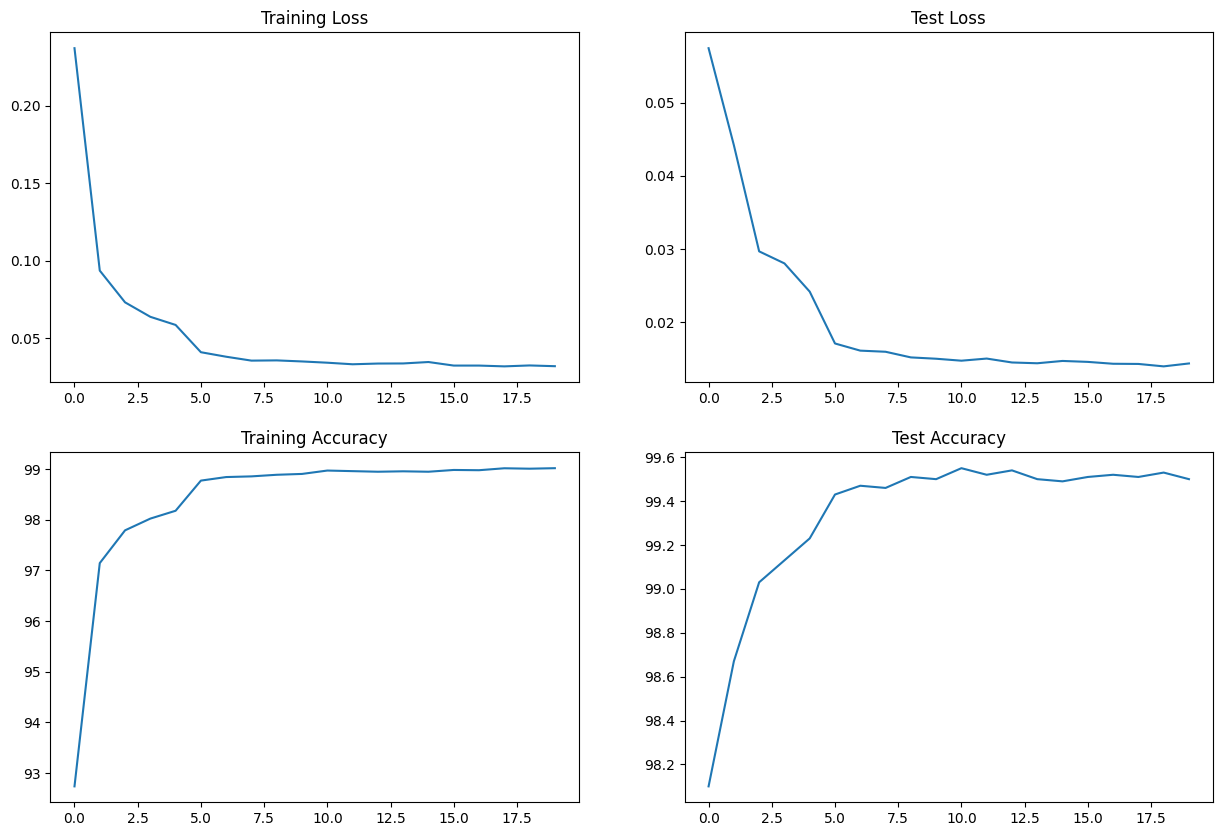

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [11]:
mnist_data = datasets.MNIST( root=config['data'].get('dir_path'), download=False, transform=transforms.ToTensor() ,)
mean,std= calculate_mean_std_mnist(mnist_data)

print(mean,std)

0.13065974414348602 0.3015038073062897
